In [1]:
import sys, os
from pathlib import Path
import torch
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

/home/viplab/pt-gpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load flooding configuration file from local device or gcs

In [2]:
from ml4floods.models.config_setup import get_default_config
import pkg_resources

# Set filepath to configuration files
# config_fp = 'path/to/worldfloods_template.json'
config_fp = pkg_resources.resource_filename("ml4floods","models/configurations/worldfloods_template.json")

config = get_default_config(config_fp)
config

Loaded Config for experiment:  worldfloods_demo_test
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4cc_data_lake',
                       'channel_configuration': 'all',
                       'download': {'test': True, 'train': True, 'val': True},
                       'filter_windows': {   'apply': False,
                                             'threshold_clouds': 0.5,
                                             'version': 'v1'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 4,
                       'path_to_splits': 'worldfloods',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json',
                       'train_transformation': {'normalize': True},
                       'window_size': [256, 256]}

{'experiment_name': 'worldfloods_demo_test',
 'seed': 12,
 'model_params': {'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart',
  'model_version': 'v1',
  'hyperparameters': {'max_tile_size': 256,
   'metric_monitor': 'val_dice_loss',
   'channel_configuration': 'all',
   'label_names': ['land', 'water', 'cloud'],
   'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
   'model_type': 'linear',
   'num_classes': 3,
   'max_epochs': 10,
   'val_every': 1,
   'lr': 0.0001,
   'lr_decay': 0.5,
   'lr_patience': 2,
   'early_stopping_patience': 4,
   'num_channels': 13},
  'train': True,
  'test': True},
 'data_params': {'loader_type': 'local',
  'num_workers': 4,
  'filter_windows': {'version': 'v1', 'threshold_clouds': 0.5, 'apply': False},
  'download': {'train': True, 'val': True, 'test': True},
  'bucket_id': 'ml4cc_data_lake',
  'path_to_splits': 'worldfloods',
  'train_test_split_file': '2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json',
  'input_folder': '

## Step 2: Setup Dataloader

In [3]:
config.experiment_name = 'training_flooding_bgri'
config.data_params.channel_configuration = 'bgri'
config.model_params.hyperparameters.channel_configuration = 'bgri'
config.model_params.hyperparameters.num_channels = 4
config.data_params.bucket_id = ""
config.model_params

{'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart',
 'model_version': 'v1',
 'hyperparameters': {'max_tile_size': 256,
  'metric_monitor': 'val_dice_loss',
  'channel_configuration': 'bgri',
  'label_names': ['land', 'water', 'cloud'],
  'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
  'model_type': 'linear',
  'num_classes': 3,
  'max_epochs': 10,
  'val_every': 1,
  'lr': 0.0001,
  'lr_decay': 0.5,
  'lr_patience': 2,
  'early_stopping_patience': 4,
  'num_channels': 4},
 'train': True,
 'test': True}

In [4]:
%%time

from ml4floods.models.dataset_setup import get_dataset

config.data_params.batch_size = 96 # control this depending on the space on your GPU!
config.data_params.loader_type = 'local'
config.data_params.path_to_splits = "/mnt/d/Flooding/worldfloods_v1_0" # local folder to download the data
config.data_params.train_test_split_file = "/mnt/d/Flooding/train_test_split_local.json"

config.data_params["download"] = {"train": True, "val": True, "test": True} # download only test data
# config.data_params.train_test_split_file = "2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json" # use this to train with all the data
config.data_params.num_workers = 24

# If files are not in config.data_params.path_to_splits this will trigger the download of the products.
dataset = get_dataset(config.data_params)

train 194151  tiles
val 1284  tiles
test 11  tiles
CPU times: user 1.42 s, sys: 1.48 s, total: 2.9 s
Wall time: 1.45 s


## Verfify data loader

#### Verify training data
Data format here: https://github.com/spaceml-org/ml4floods/blob/891fe602880586e7ac821d2f282bf5ec9d4c0795/ml4floods/data/worldfloods/dataset.py#L106

In [5]:
train_dl = dataset.train_dataloader()
train_dl_iter = iter(train_dl)
print(len(train_dl_iter))
batch_train = next(train_dl_iter)

# batch_train["image"].shape, batch_train["mask"].shape

2023


Verify validation data

In [6]:
val_dl = dataset.val_dataloader()

val_dl_iter = iter(val_dl)
print(len(val_dl_iter))
batch_val = next(val_dl_iter)

# batch_val["image"].shape, batch_val["mask"].shape

14


In [7]:
test_dl = dataset.test_dataloader()

test_dl_iter = iter(test_dl)
print(len(test_dl_iter))

batch_test = next(test_dl_iter)
# batch_test["image"].shape, batch_test["mask"].shape

11


### Plot batch by using ml4flood model 
check detail here: https://github.com/spaceml-org/ml4floods/blob/891fe602880586e7ac821d2f282bf5ec9d4c0795/ml4floods/data/worldfloods/dataset.py#L106

In [8]:
import importlib
import matplotlib.pyplot as plt
from models import flooding_model
flooding_model = importlib.reload(flooding_model)

# batch_train_rgb = flooding_model.batch_to_unnorm_rgb(batch_train["image"])
# # batch_train_rgb.shape
# plt.imshow(batch_train_rgb[2])
# plt.show()

# batch_train_rgb_mask = flooding_model.batch_mask_to_rgb(batch_train["mask"])
# plt.imshow(batch_train_rgb_mask[2])
# plt.colorbar()
# plt.show()


## Step 3: Setup Model

In [9]:
 # folder to store the trained model (it will create a subfolder with the name of the experiment)
config.model_params

{'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart',
 'model_version': 'v1',
 'hyperparameters': {'max_tile_size': 256,
  'metric_monitor': 'val_dice_loss',
  'channel_configuration': 'bgri',
  'label_names': ['land', 'water', 'cloud'],
  'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
  'model_type': 'linear',
  'num_classes': 3,
  'max_epochs': 10,
  'val_every': 1,
  'lr': 0.0001,
  'lr_decay': 0.5,
  'lr_patience': 2,
  'early_stopping_patience': 4,
  'num_channels': 4},
 'train': True,
 'test': True}

In [10]:
config.model_params.model_folder = "train_models" 
os.makedirs("train_models", exist_ok=True)
config.model_params.test = False
config.model_params.train = True
config.model_params.hyperparameters.model_type = "unet_simple" # Currently implemented: simplecnn, unet, linear, unet_simple
config.model_params.hyperparameters.metric_monitor = 'val_iou_loss' #IoU Loss
# config.model_params.hyperparameters.num_channels = 3

In [11]:
import copy
from models.flooding_model import WorldFloodsModel, DistilledTrainingModel, WorldFloodsModel2, WorldFloodsModel1
importlib.reload(flooding_model)
simple_model_params = copy.deepcopy(config.model_params)
# simple_model_params['hyperparameters']['model_type']="unet_simple"

# model = DistilledTrainingModel(config.model_params, simple_model_params)
model = WorldFloodsModel2(config.model_params) # Focal loss and IoU loss
# model = WorldFloodsModel1(config.model_params) # Focal loss and Dice loss
net = model.network
net

SimpleUNet(
  (dconv_down1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(ker

In [12]:
# Compuatation complexity of network
from ptflops import get_model_complexity_info
macs, params = get_model_complexity_info(net, (config.model_params.hyperparameters.num_channels, config.model_params.hyperparameters.max_tile_size, config.model_params.hyperparameters.max_tile_size), as_strings=True, print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

SimpleUNet(
  1.95 M, 100.000% Params, 10.69 GMac, 100.000% MACs, 
  (dconv_down1): Sequential(
    10.43 k, 0.536% Params, 687.87 MMac, 6.437% MACs, 
    (0): Conv2d(1.18 k, 0.061% Params, 77.59 MMac, 0.726% MACs, 4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 2.1 MMac, 0.020% MACs, inplace=True)
    (2): Conv2d(9.25 k, 0.475% Params, 606.08 MMac, 5.672% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(0, 0.000% Params, 2.1 MMac, 0.020% MACs, inplace=True)
  )
  (dconv_down2): Sequential(
    55.42 k, 2.846% Params, 910.16 MMac, 8.518% MACs, 
    (0): Conv2d(18.5 k, 0.950% Params, 303.04 MMac, 2.836% MACs, 32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 1.05 MMac, 0.010% MACs, inplace=True)
    (2): Conv2d(36.93 k, 1.896% Params, 605.03 MMac, 5.662% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(0, 0.000% Params, 1.05 MMac, 0.010% MACs, in

In [13]:
setup_weights_and_biases = True
if setup_weights_and_biases:
    import wandb
    from pytorch_lightning.loggers import WandbLogger

    # UNCOMMENT ON FIRST RUN TO LOGIN TO Weights and Biases (only needs to be done once)
    wandb.login()
    run = wandb.init()

    # Specifies who is logging the experiment to wandb
    config['wandb_entity'] = 'ml4floods'
    # Specifies which wandb project to log to, multiple runs can exist in the same project
    config['wandb_project'] = 'worldfloods-trongan-test'

    wandb_logger = WandbLogger(
        name=config.experiment_name,
        project=config.wandb_project, 
        entity=config.wandb_entity
    )
else:
    wandb_logger = None

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: trongan93. Use `wandb login --relogin` to force relogin


/home/viplab/pt-gpu/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [14]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

experiment_path = f"{config.model_params.model_folder}/{config.experiment_name}"

checkpoint_callback = ModelCheckpoint(
    dirpath=f"{experiment_path}/checkpoint",
    save_top_k=True,
    verbose=True,
    monitor='val_iou_loss',
    mode='min',
#     prefix=''
)

early_stop_callback = EarlyStopping(
    monitor='val_iou_loss',
    patience=10,
    strict=False,
    verbose=False,
    mode='min'
)
# monitor='val_iou_loss'
# monitor='val_dice_loss'


callbacks = [checkpoint_callback, early_stop_callback]

print(f"The trained model will be stored in {config.model_params.model_folder}/{config.experiment_name}")

The trained model will be stored in train_models/training_flooding_bgri


In [15]:
from pytorch_lightning import Trainer

config.gpus = 2 # which gpu to use 
# config.gpus = None # to not use GPU
config.model_params.hyperparameters.max_epochs = 100 # train for maximum 4 epochs

trainer = Trainer(
    fast_dev_run=False,
    logger=wandb_logger,
    callbacks=callbacks,
    default_root_dir=f"{config.model_params.model_folder}/{config.experiment_name}",
    accumulate_grad_batches=1,
    gradient_clip_val=0.0,
    auto_lr_find=False,
    benchmark=False,
    max_epochs=config.model_params.hyperparameters.max_epochs,
    check_val_every_n_epoch=config.model_params.hyperparameters.val_every,
    strategy='dp',
    accelerator='gpu',
    devices=config.gpus
    # resume_from_checkpoint='~/Projects/github/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=0-step=24269.ckpt'
)
# config
# https://wandb.ai/wandb/wandb-lightning/reports/Multi-GPU-Training-Using-PyTorch-Lightning--VmlldzozMTk3NTk
# resume_from_checkpoint='/home/eeaiserver/viplab_projects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=39-step=161799.ckpt'
# resume_from_checkpoint='~/Projects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=30-step=47026.ckpt'

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model, dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | network | SimpleUNet | 1.9 M 
---------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.789     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/viplab/pt-gpu/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|████████████████████████████████████▋| 2023/2037 [14:39<00:06,  2.30it/s, loss=1.07, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|█████████████████████████████████████| 2037/2037 [14:58<00:00,  2.27it/s, loss=1.07, v_num=ca2u]

Epoch 0, global step 2023: 'val_iou_loss' reached 0.37734 (best 0.37734), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=0-step=2023.ckpt' as top True


Epoch 1:   1%|▍                                      | 23/2037 [00:16<24:24,  1.38it/s, loss=1.07, v_num=ca2u]

Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/viplab/pt-gpu/lib/python3.10/site-packages/wandb/vendor/watchdog/observers/api.py", line 199, in run
    self.dispatch_events(self.event_queue, self.timeout)
  File "/home/viplab/pt-gpu/lib/python3.10/site-packages/wandb/vendor/watchdog/observers/api.py", line 368, in dispatch_events
    handler.dispatch(event)
  File "/home/viplab/pt-gpu/lib/python3.10/site-packages/wandb/vendor/watchdog/events.py", line 454, in dispatch
    _method_map[event_type](event)
  File "/home/viplab/pt-gpu/lib/python3.10/site-packages/wandb/filesync/dir_watcher.py", line 309, in _on_file_moved
    del self._file_event_handlers[old_save_name]
KeyError: 'media/images/train_overlay_65_13c0915d226521fb56bb.png'


Epoch 1:  99%|████████████████████████████████████▋| 2023/2037 [19:14<00:07,  1.75it/s, loss=1.01, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|█████████████████████████████████████| 2037/2037 [19:34<00:00,  1.73it/s, loss=1.01, v_num=ca2u]

Epoch 1, global step 4046: 'val_iou_loss' reached 0.37713 (best 0.37713), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=1-step=4046.ckpt' as top True


Epoch 2:  99%|████████████████████████████████████▋| 2023/2037 [19:16<00:08,  1.75it/s, loss=0.95, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████████████████████████████████| 2037/2037 [19:37<00:00,  1.73it/s, loss=0.95, v_num=ca2u]

Epoch 2, global step 6069: 'val_iou_loss' reached 0.27842 (best 0.27842), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=2-step=6069.ckpt' as top True


Epoch 3:  99%|███████████████████████████████████▊| 2023/2037 [19:25<00:08,  1.74it/s, loss=0.961, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|████████████████████████████████████| 2037/2037 [19:45<00:00,  1.72it/s, loss=0.961, v_num=ca2u]

Epoch 3, global step 8092: 'val_iou_loss' reached 0.27793 (best 0.27793), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=3-step=8092.ckpt' as top True


Epoch 4:  99%|███████████████████████████████████▊| 2023/2037 [19:20<00:08,  1.74it/s, loss=0.959, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|████████████████████████████████████| 2037/2037 [19:40<00:00,  1.72it/s, loss=0.959, v_num=ca2u]

Epoch 4, global step 10115: 'val_iou_loss' was not in top True


Epoch 5:  99%|███████████████████████████████████▊| 2023/2037 [19:28<00:08,  1.73it/s, loss=0.946, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|████████████████████████████████████| 2037/2037 [19:49<00:00,  1.71it/s, loss=0.946, v_num=ca2u]

Epoch 5, global step 12138: 'val_iou_loss' reached 0.26721 (best 0.26721), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=5-step=12138.ckpt' as top True


Epoch 6:  99%|███████████████████████████████████▊| 2023/2037 [19:38<00:08,  1.72it/s, loss=0.953, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|████████████████████████████████████| 2037/2037 [19:58<00:00,  1.70it/s, loss=0.953, v_num=ca2u]

Epoch 6, global step 14161: 'val_iou_loss' was not in top True


Epoch 7:  99%|███████████████████████████████████▊| 2023/2037 [19:31<00:08,  1.73it/s, loss=0.912, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|████████████████████████████████████| 2037/2037 [19:51<00:00,  1.71it/s, loss=0.912, v_num=ca2u]

Epoch 7, global step 16184: 'val_iou_loss' reached 0.25548 (best 0.25548), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=7-step=16184.ckpt' as top True


Epoch 8:  99%|███████████████████████████████████▊| 2023/2037 [19:30<00:08,  1.73it/s, loss=0.969, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|████████████████████████████████████| 2037/2037 [19:51<00:00,  1.71it/s, loss=0.969, v_num=ca2u]

Epoch 8, global step 18207: 'val_iou_loss' was not in top True


Epoch 9:  99%|███████████████████████████████████▊| 2023/2037 [19:43<00:08,  1.71it/s, loss=0.983, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|████████████████████████████████████| 2037/2037 [20:04<00:00,  1.69it/s, loss=0.983, v_num=ca2u]

Epoch 9, global step 20230: 'val_iou_loss' was not in top True


Epoch 10:  99%|██████████████████████████████████▊| 2023/2037 [19:57<00:08,  1.69it/s, loss=0.948, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 10: 100%|███████████████████████████████████| 2037/2037 [20:18<00:00,  1.67it/s, loss=0.948, v_num=ca2u]

Epoch 10, global step 22253: 'val_iou_loss' was not in top True


Epoch 00011: reducing learning rate of group 0 to 5.0000e-05.
Epoch 11:  99%|███████████████████████████████████▊| 2023/2037 [19:47<00:08,  1.70it/s, loss=0.95, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 11: 100%|████████████████████████████████████| 2037/2037 [20:08<00:00,  1.69it/s, loss=0.95, v_num=ca2u]

Epoch 11, global step 24276: 'val_iou_loss' was not in top True


Epoch 12:  99%|██████████████████████████████████▊| 2023/2037 [20:04<00:08,  1.68it/s, loss=0.945, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 12: 100%|███████████████████████████████████| 2037/2037 [20:25<00:00,  1.66it/s, loss=0.945, v_num=ca2u]

Epoch 12, global step 26299: 'val_iou_loss' was not in top True


Epoch 13:  99%|██████████████████████████████████▊| 2023/2037 [19:58<00:08,  1.69it/s, loss=0.926, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 13: 100%|███████████████████████████████████| 2037/2037 [20:19<00:00,  1.67it/s, loss=0.926, v_num=ca2u]

Epoch 13, global step 28322: 'val_iou_loss' was not in top True


Epoch 00014: reducing learning rate of group 0 to 2.5000e-05.
Epoch 14:  99%|██████████████████████████████████▊| 2023/2037 [19:49<00:08,  1.70it/s, loss=0.901, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 14: 100%|███████████████████████████████████| 2037/2037 [20:10<00:00,  1.68it/s, loss=0.901, v_num=ca2u]

Epoch 14, global step 30345: 'val_iou_loss' was not in top True


Epoch 15:  99%|███████████████████████████████████▊| 2023/2037 [19:50<00:08,  1.70it/s, loss=0.91, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 15: 100%|████████████████████████████████████| 2037/2037 [20:11<00:00,  1.68it/s, loss=0.91, v_num=ca2u]

Epoch 15, global step 32368: 'val_iou_loss' was not in top True


Epoch 16:  99%|██████████████████████████████████▊| 2023/2037 [19:56<00:08,  1.69it/s, loss=0.918, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 16: 100%|███████████████████████████████████| 2037/2037 [20:16<00:00,  1.67it/s, loss=0.918, v_num=ca2u]

Epoch 16, global step 34391: 'val_iou_loss' reached 0.25159 (best 0.25159), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=16-step=34391.ckpt' as top True


Epoch 17:  99%|██████████████████████████████████▊| 2023/2037 [20:18<00:08,  1.66it/s, loss=0.886, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 17: 100%|███████████████████████████████████| 2037/2037 [20:39<00:00,  1.64it/s, loss=0.886, v_num=ca2u]

Epoch 17, global step 36414: 'val_iou_loss' reached 0.24951 (best 0.24951), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=17-step=36414.ckpt' as top True


Epoch 18:  99%|██████████████████████████████████▊| 2023/2037 [20:37<00:08,  1.64it/s, loss=0.884, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 18: 100%|███████████████████████████████████| 2037/2037 [20:58<00:00,  1.62it/s, loss=0.884, v_num=ca2u]

Epoch 18, global step 38437: 'val_iou_loss' was not in top True


Epoch 19:  99%|██████████████████████████████████▊| 2023/2037 [20:13<00:08,  1.67it/s, loss=0.911, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 19: 100%|███████████████████████████████████| 2037/2037 [20:33<00:00,  1.65it/s, loss=0.911, v_num=ca2u]

Epoch 19, global step 40460: 'val_iou_loss' reached 0.24900 (best 0.24900), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=19-step=40460.ckpt' as top True


Epoch 20:  99%|██████████████████████████████████▊| 2023/2037 [21:30<00:08,  1.57it/s, loss=0.862, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 20: 100%|███████████████████████████████████| 2037/2037 [21:51<00:00,  1.55it/s, loss=0.862, v_num=ca2u]

Epoch 20, global step 42483: 'val_iou_loss' was not in top True


Epoch 21:  99%|███████████████████████████████████▊| 2023/2037 [21:02<00:08,  1.60it/s, loss=0.88, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 21: 100%|████████████████████████████████████| 2037/2037 [21:22<00:00,  1.59it/s, loss=0.88, v_num=ca2u]

Epoch 21, global step 44506: 'val_iou_loss' was not in top True


Epoch 22:  99%|██████████████████████████████████▊| 2023/2037 [19:54<00:08,  1.69it/s, loss=0.889, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 22: 100%|███████████████████████████████████| 2037/2037 [20:14<00:00,  1.68it/s, loss=0.889, v_num=ca2u]

Epoch 22, global step 46529: 'val_iou_loss' was not in top True


Epoch 00023: reducing learning rate of group 0 to 1.2500e-05.
Epoch 23:  99%|██████████████████████████████████▊| 2023/2037 [19:40<00:08,  1.71it/s, loss=0.895, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 23: 100%|███████████████████████████████████| 2037/2037 [20:01<00:00,  1.70it/s, loss=0.895, v_num=ca2u]

Epoch 23, global step 48552: 'val_iou_loss' reached 0.24645 (best 0.24645), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=23-step=48552.ckpt' as top True


Epoch 24:  99%|██████████████████████████████████▊| 2023/2037 [19:21<00:08,  1.74it/s, loss=0.916, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 24: 100%|███████████████████████████████████| 2037/2037 [19:42<00:00,  1.72it/s, loss=0.916, v_num=ca2u]

Epoch 24, global step 50575: 'val_iou_loss' reached 0.24491 (best 0.24491), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=24-step=50575.ckpt' as top True


Epoch 25:  99%|██████████████████████████████████▊| 2023/2037 [19:35<00:08,  1.72it/s, loss=0.899, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 25: 100%|███████████████████████████████████| 2037/2037 [19:56<00:00,  1.70it/s, loss=0.899, v_num=ca2u]

Epoch 25, global step 52598: 'val_iou_loss' was not in top True


Epoch 26:  99%|██████████████████████████████████▊| 2023/2037 [19:30<00:08,  1.73it/s, loss=0.858, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 26: 100%|███████████████████████████████████| 2037/2037 [19:50<00:00,  1.71it/s, loss=0.858, v_num=ca2u]

Epoch 26, global step 54621: 'val_iou_loss' was not in top True


Epoch 27:  99%|██████████████████████████████████▊| 2023/2037 [19:52<00:08,  1.70it/s, loss=0.891, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 27: 100%|███████████████████████████████████| 2037/2037 [20:14<00:00,  1.68it/s, loss=0.891, v_num=ca2u]

Epoch 27, global step 56644: 'val_iou_loss' reached 0.24084 (best 0.24084), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=27-step=56644.ckpt' as top True


Epoch 28:  99%|███████████████████████████████████▊| 2023/2037 [19:11<00:07,  1.76it/s, loss=0.88, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 28: 100%|████████████████████████████████████| 2037/2037 [19:34<00:00,  1.73it/s, loss=0.88, v_num=ca2u]

Epoch 28, global step 58667: 'val_iou_loss' was not in top True


Epoch 29:  99%|██████████████████████████████████▊| 2023/2037 [18:42<00:07,  1.80it/s, loss=0.848, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 29: 100%|███████████████████████████████████| 2037/2037 [19:05<00:00,  1.78it/s, loss=0.848, v_num=ca2u]

Epoch 29, global step 60690: 'val_iou_loss' was not in top True


Epoch 30:  99%|██████████████████████████████████▊| 2023/2037 [18:49<00:07,  1.79it/s, loss=0.859, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 30: 100%|███████████████████████████████████| 2037/2037 [19:11<00:00,  1.77it/s, loss=0.859, v_num=ca2u]

Epoch 30, global step 62713: 'val_iou_loss' reached 0.24052 (best 0.24052), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=30-step=62713.ckpt' as top True


Epoch 31:  99%|██████████████████████████████████▊| 2023/2037 [18:53<00:07,  1.78it/s, loss=0.895, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 31: 100%|███████████████████████████████████| 2037/2037 [19:16<00:00,  1.76it/s, loss=0.895, v_num=ca2u]

Epoch 31, global step 64736: 'val_iou_loss' was not in top True


Epoch 32:  99%|███████████████████████████████████▊| 2023/2037 [18:48<00:07,  1.79it/s, loss=0.91, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 32: 100%|████████████████████████████████████| 2037/2037 [19:10<00:00,  1.77it/s, loss=0.91, v_num=ca2u]

Epoch 32, global step 66759: 'val_iou_loss' reached 0.23859 (best 0.23859), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=32-step=66759.ckpt' as top True


Epoch 33:  99%|██████████████████████████████████▊| 2023/2037 [18:49<00:07,  1.79it/s, loss=0.879, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 33: 100%|███████████████████████████████████| 2037/2037 [19:12<00:00,  1.77it/s, loss=0.879, v_num=ca2u]

Epoch 33, global step 68782: 'val_iou_loss' was not in top True


Epoch 34:  99%|██████████████████████████████████▊| 2023/2037 [18:41<00:07,  1.80it/s, loss=0.886, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 34: 100%|███████████████████████████████████| 2037/2037 [19:04<00:00,  1.78it/s, loss=0.886, v_num=ca2u]

Epoch 34, global step 70805: 'val_iou_loss' was not in top True


Epoch 35:  99%|██████████████████████████████████▊| 2023/2037 [18:34<00:07,  1.82it/s, loss=0.913, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 35: 100%|███████████████████████████████████| 2037/2037 [18:55<00:00,  1.79it/s, loss=0.913, v_num=ca2u]

Epoch 35, global step 72828: 'val_iou_loss' was not in top True


Epoch 00036: reducing learning rate of group 0 to 6.2500e-06.
Epoch 36:  99%|██████████████████████████████████▊| 2023/2037 [18:32<00:07,  1.82it/s, loss=0.856, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 36: 100%|███████████████████████████████████| 2037/2037 [18:54<00:00,  1.80it/s, loss=0.856, v_num=ca2u]

Epoch 36, global step 74851: 'val_iou_loss' was not in top True


Epoch 37:  99%|██████████████████████████████████▊| 2023/2037 [18:25<00:07,  1.83it/s, loss=0.897, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 37: 100%|███████████████████████████████████| 2037/2037 [18:47<00:00,  1.81it/s, loss=0.897, v_num=ca2u]

Epoch 37, global step 76874: 'val_iou_loss' was not in top True


Epoch 38:  99%|██████████████████████████████████▊| 2023/2037 [18:15<00:07,  1.85it/s, loss=0.866, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 38: 100%|███████████████████████████████████| 2037/2037 [18:36<00:00,  1.82it/s, loss=0.866, v_num=ca2u]

Epoch 38, global step 78897: 'val_iou_loss' reached 0.23709 (best 0.23709), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=38-step=78897.ckpt' as top True


Epoch 39:  99%|██████████████████████████████████▊| 2023/2037 [18:21<00:07,  1.84it/s, loss=0.913, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 39: 100%|███████████████████████████████████| 2037/2037 [18:42<00:00,  1.81it/s, loss=0.913, v_num=ca2u]

Epoch 39, global step 80920: 'val_iou_loss' was not in top True


Epoch 40:  99%|██████████████████████████████████▊| 2023/2037 [18:23<00:07,  1.83it/s, loss=0.926, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 40: 100%|███████████████████████████████████| 2037/2037 [18:45<00:00,  1.81it/s, loss=0.926, v_num=ca2u]

Epoch 40, global step 82943: 'val_iou_loss' was not in top True


Epoch 41:  99%|██████████████████████████████████▊| 2023/2037 [18:10<00:07,  1.86it/s, loss=0.931, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 41: 100%|███████████████████████████████████| 2037/2037 [18:32<00:00,  1.83it/s, loss=0.931, v_num=ca2u]

Epoch 41, global step 84966: 'val_iou_loss' was not in top True


Epoch 00042: reducing learning rate of group 0 to 3.1250e-06.
Epoch 42:  99%|██████████████████████████████████▊| 2023/2037 [18:14<00:07,  1.85it/s, loss=0.875, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 42: 100%|███████████████████████████████████| 2037/2037 [18:36<00:00,  1.83it/s, loss=0.875, v_num=ca2u]

Epoch 42, global step 86989: 'val_iou_loss' was not in top True


Epoch 43:  99%|██████████████████████████████████▊| 2023/2037 [18:19<00:07,  1.84it/s, loss=0.887, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 43: 100%|███████████████████████████████████| 2037/2037 [18:41<00:00,  1.82it/s, loss=0.887, v_num=ca2u]

Epoch 43, global step 89012: 'val_iou_loss' reached 0.23702 (best 0.23702), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=43-step=89012.ckpt' as top True


Epoch 44:  99%|██████████████████████████████████▊| 2023/2037 [18:28<00:07,  1.82it/s, loss=0.877, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 44: 100%|███████████████████████████████████| 2037/2037 [18:50<00:00,  1.80it/s, loss=0.877, v_num=ca2u]

Epoch 44, global step 91035: 'val_iou_loss' reached 0.23673 (best 0.23673), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=44-step=91035.ckpt' as top True


Epoch 45:  99%|██████████████████████████████████▊| 2023/2037 [18:34<00:07,  1.82it/s, loss=0.895, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 45: 100%|███████████████████████████████████| 2037/2037 [18:55<00:00,  1.79it/s, loss=0.895, v_num=ca2u]

Epoch 45, global step 93058: 'val_iou_loss' was not in top True


Epoch 46:  99%|██████████████████████████████████▊| 2023/2037 [18:25<00:07,  1.83it/s, loss=0.886, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 46: 100%|███████████████████████████████████| 2037/2037 [18:47<00:00,  1.81it/s, loss=0.886, v_num=ca2u]

Epoch 46, global step 95081: 'val_iou_loss' reached 0.23638 (best 0.23638), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=46-step=95081.ckpt' as top True


Epoch 47:  99%|██████████████████████████████████▊| 2023/2037 [18:22<00:07,  1.83it/s, loss=0.854, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 47: 100%|███████████████████████████████████| 2037/2037 [18:44<00:00,  1.81it/s, loss=0.854, v_num=ca2u]

Epoch 47, global step 97104: 'val_iou_loss' was not in top True


Epoch 48:  99%|██████████████████████████████████▊| 2023/2037 [18:18<00:07,  1.84it/s, loss=0.876, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 48: 100%|███████████████████████████████████| 2037/2037 [18:40<00:00,  1.82it/s, loss=0.876, v_num=ca2u]

Epoch 48, global step 99127: 'val_iou_loss' was not in top True


Epoch 49:  99%|██████████████████████████████████▊| 2023/2037 [18:31<00:07,  1.82it/s, loss=0.845, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 49: 100%|███████████████████████████████████| 2037/2037 [18:53<00:00,  1.80it/s, loss=0.845, v_num=ca2u]

Epoch 49, global step 101150: 'val_iou_loss' was not in top True


Epoch 00050: reducing learning rate of group 0 to 1.5625e-06.
Epoch 50:  99%|██████████████████████████████████▊| 2023/2037 [18:24<00:07,  1.83it/s, loss=0.897, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 50: 100%|███████████████████████████████████| 2037/2037 [18:46<00:00,  1.81it/s, loss=0.897, v_num=ca2u]

Epoch 50, global step 103173: 'val_iou_loss' was not in top True


Epoch 51:  99%|██████████████████████████████████▊| 2023/2037 [18:30<00:07,  1.82it/s, loss=0.903, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 51: 100%|███████████████████████████████████| 2037/2037 [18:51<00:00,  1.80it/s, loss=0.903, v_num=ca2u]

Epoch 51, global step 105196: 'val_iou_loss' was not in top True


Epoch 52:  99%|██████████████████████████████████▊| 2023/2037 [18:16<00:07,  1.85it/s, loss=0.878, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 52: 100%|███████████████████████████████████| 2037/2037 [18:37<00:00,  1.82it/s, loss=0.878, v_num=ca2u]

Epoch 52, global step 107219: 'val_iou_loss' was not in top True


Epoch 00053: reducing learning rate of group 0 to 7.8125e-07.
Epoch 53:  99%|██████████████████████████████████▊| 2023/2037 [18:28<00:07,  1.82it/s, loss=0.843, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 53: 100%|███████████████████████████████████| 2037/2037 [18:50<00:00,  1.80it/s, loss=0.843, v_num=ca2u]

Epoch 53, global step 109242: 'val_iou_loss' was not in top True


Epoch 54:  99%|██████████████████████████████████▊| 2023/2037 [18:32<00:07,  1.82it/s, loss=0.883, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 54: 100%|███████████████████████████████████| 2037/2037 [18:53<00:00,  1.80it/s, loss=0.883, v_num=ca2u]

Epoch 54, global step 111265: 'val_iou_loss' was not in top True


Epoch 55:  99%|██████████████████████████████████▊| 2023/2037 [18:38<00:07,  1.81it/s, loss=0.874, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 55: 100%|███████████████████████████████████| 2037/2037 [19:00<00:00,  1.79it/s, loss=0.874, v_num=ca2u]

Epoch 55, global step 113288: 'val_iou_loss' was not in top True


Epoch 00056: reducing learning rate of group 0 to 3.9063e-07.
Epoch 56:  99%|██████████████████████████████████▊| 2023/2037 [18:27<00:07,  1.83it/s, loss=0.871, v_num=ca2u]
Validation: 0it [00:00, ?it/s]
Epoch 56: 100%|███████████████████████████████████| 2037/2037 [18:48<00:00,  1.80it/s, loss=0.871, v_num=ca2u]

Epoch 56, global step 115311: 'val_iou_loss' was not in top True


Epoch 56: 100%|███████████████████████████████████| 2037/2037 [18:48<00:00,  1.80it/s, loss=0.871, v_num=ca2u]


In [17]:
# import torch
# Run inference on the images shown before

logits = model(batch_train["image"].to(model.device))
print(f"Shape of logits: {logits.shape}")
probs = torch.softmax(logits, dim=1)
print(f"Shape of probs: {probs.shape}")
prediction = torch.argmax(probs, dim=1).long().cpu()
print(f"Shape of prediction: {prediction.shape}")

Shape of logits: torch.Size([96, 3, 256, 256])
Shape of probs: torch.Size([96, 3, 256, 256])
Shape of prediction: torch.Size([96, 256, 256])


In [18]:
config.model_params.max_tile_size = config.model_params.hyperparameters.max_tile_size
config

{'experiment_name': 'training_flooding_bgri',
 'seed': 12,
 'model_params': {'model_folder': 'train_models',
  'model_version': 'v1',
  'hyperparameters': {'max_tile_size': 256,
   'metric_monitor': 'val_iou_loss',
   'channel_configuration': 'bgri',
   'label_names': ['land', 'water', 'cloud'],
   'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
   'model_type': 'unet_simple',
   'num_classes': 3,
   'max_epochs': 100,
   'val_every': 1,
   'lr': 0.0001,
   'lr_decay': 0.5,
   'lr_patience': 2,
   'early_stopping_patience': 4,
   'num_channels': 4},
  'train': True,
  'test': False,
  'max_tile_size': 256},
 'data_params': {'loader_type': 'local',
  'num_workers': 24,
  'filter_windows': {'version': 'v1', 'threshold_clouds': 0.5, 'apply': False},
  'download': {'train': True, 'val': True, 'test': True},
  'bucket_id': '',
  'path_to_splits': '/mnt/d/Flooding/worldfloods_v1_0',
  'train_test_split_file': '/mnt/d/Flooding/train_test_split_local.json',
  'input_folder': 'S2',
 

Getting model inference function
96


14it [01:26,  6.20s/it]                                                                                       


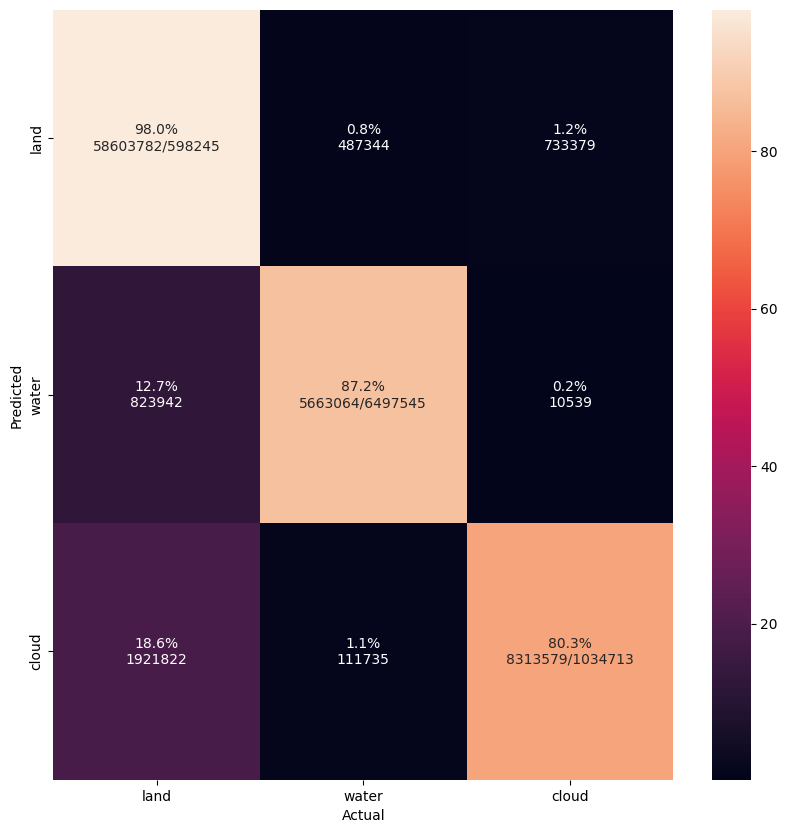

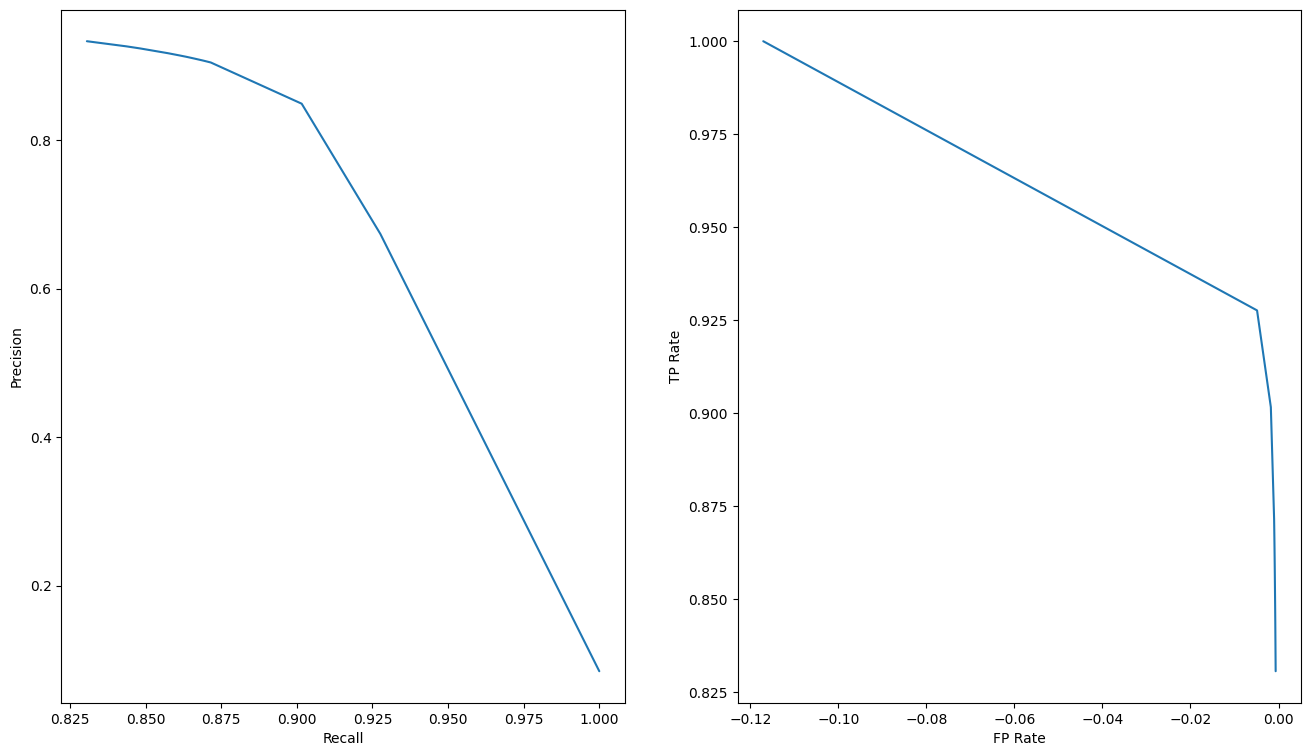

Per Class IOU {
    "cloud": 0.7495751981733882,
    "land": 0.9366074804633161,
    "water": 0.7979940884569618
}


In [19]:
# os.environ["CUDA_VISIBLE_DEVICES"]=""

# import torch
import numpy as np
from ml4floods.models.utils import metrics
from ml4floods.models.model_setup import get_model_inference_function
import pandas as pd

# model.to("cuda")
inference_function = get_model_inference_function(model, config, apply_normalization=False, activation="softmax")

# dataset2 = get_dataset(config.data_params)
dl = dataset.val_dataloader() # pytorch Dataloader
print(str(dl.batch_size))

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

thresholds_water = [0,1e-3,1e-2]+np.arange(0.5,.96,.05).tolist() + [.99,.995,.999]

mets = metrics.compute_metrics(
    dl,
    inference_function, 
    thresholds_water=thresholds_water, 
    plot=False, convert_targets=False)

label_names = ["land", "water", "cloud"]
metrics.plot_metrics(mets, label_names)

In [20]:
if hasattr(dl.dataset, "image_files"):
    cems_code = [os.path.basename(f).split("_")[0] for f in dl.dataset.image_files]
else:
    cems_code = [os.path.basename(f.file_name).split("_")[0] for f in dl.dataset.list_of_windows]

iou_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_iou,
                                                    label_names=[f"IoU_{l}"for l in ["land", "water", "cloud"]]))

recall_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_recall,
                                                       label_names=[f"Recall_{l}"for l in ["land", "water", "cloud"]]))

join_data_per_code = pd.merge(recall_per_code,iou_per_code,on="code")
join_data_per_code = join_data_per_code.set_index("code")
join_data_per_code = join_data_per_code*100
print(f"Mean values across flood events: {join_data_per_code.mean(axis=0).to_dict()}")
join_data_per_code

Mean values across flood events: {'Recall_land': 97.44902625047115, 'Recall_water': 74.94666647243137, 'Recall_cloud': 72.63499968549026, 'IoU_land': 94.21588419972674, 'IoU_water': 63.70928224128477, 'IoU_cloud': 65.63191441006056}


,Recall_land,Recall_water,Recall_cloud,IoU_land,IoU_water,IoU_cloud
code,,,,,,
EMSR271,95.807277,85.558170,92.488198,94.552723,57.571931,82.119254
EMSR279,95.901509,64.869975,78.890148,85.084838,55.275192,73.773585
EMSR280,99.434919,92.344167,74.736101,98.281168,89.070773,63.767370
EMSR287,99.892986,64.799148,3.210464,98.909135,63.185851,2.023988
RS2,95.372315,78.094908,92.275346,92.474913,57.956832,83.991037
ST1,98.285152,64.013631,94.209741,95.992529,59.195115,88.116252


In [21]:
torch.save(model.state_dict(),f"{experiment_path}/model_irirnir_worldflood_model_1_epoch_2_adaptive_gamma_alpha_0_001.pt")
# Save cofig file in experiment_path
config_file_path = f"{experiment_path}/config_irirnir_worldflood_model_1_epoch_2_adaptive_gamma_alpha_0_001.json"
import json
with open(config_file_path, 'w') as f:
    json.dump(config, f)

In [22]:
# Run inference on the images shown before

logits = model(batch_val["image"].to(model.device))
print(f"Shape of logits: {logits.shape}")
probs = torch.softmax(logits, dim=1)
print(f"Shape of probs: {probs.shape}")
prediction = torch.argmax(probs, dim=1).long().cpu()
print(f"Shape of prediction: {prediction.shape}")

Shape of logits: torch.Size([96, 3, 256, 256])
Shape of probs: torch.Size([96, 3, 256, 256])
Shape of prediction: torch.Size([96, 256, 256])


(4, 1, 1)
(4, 1, 1)


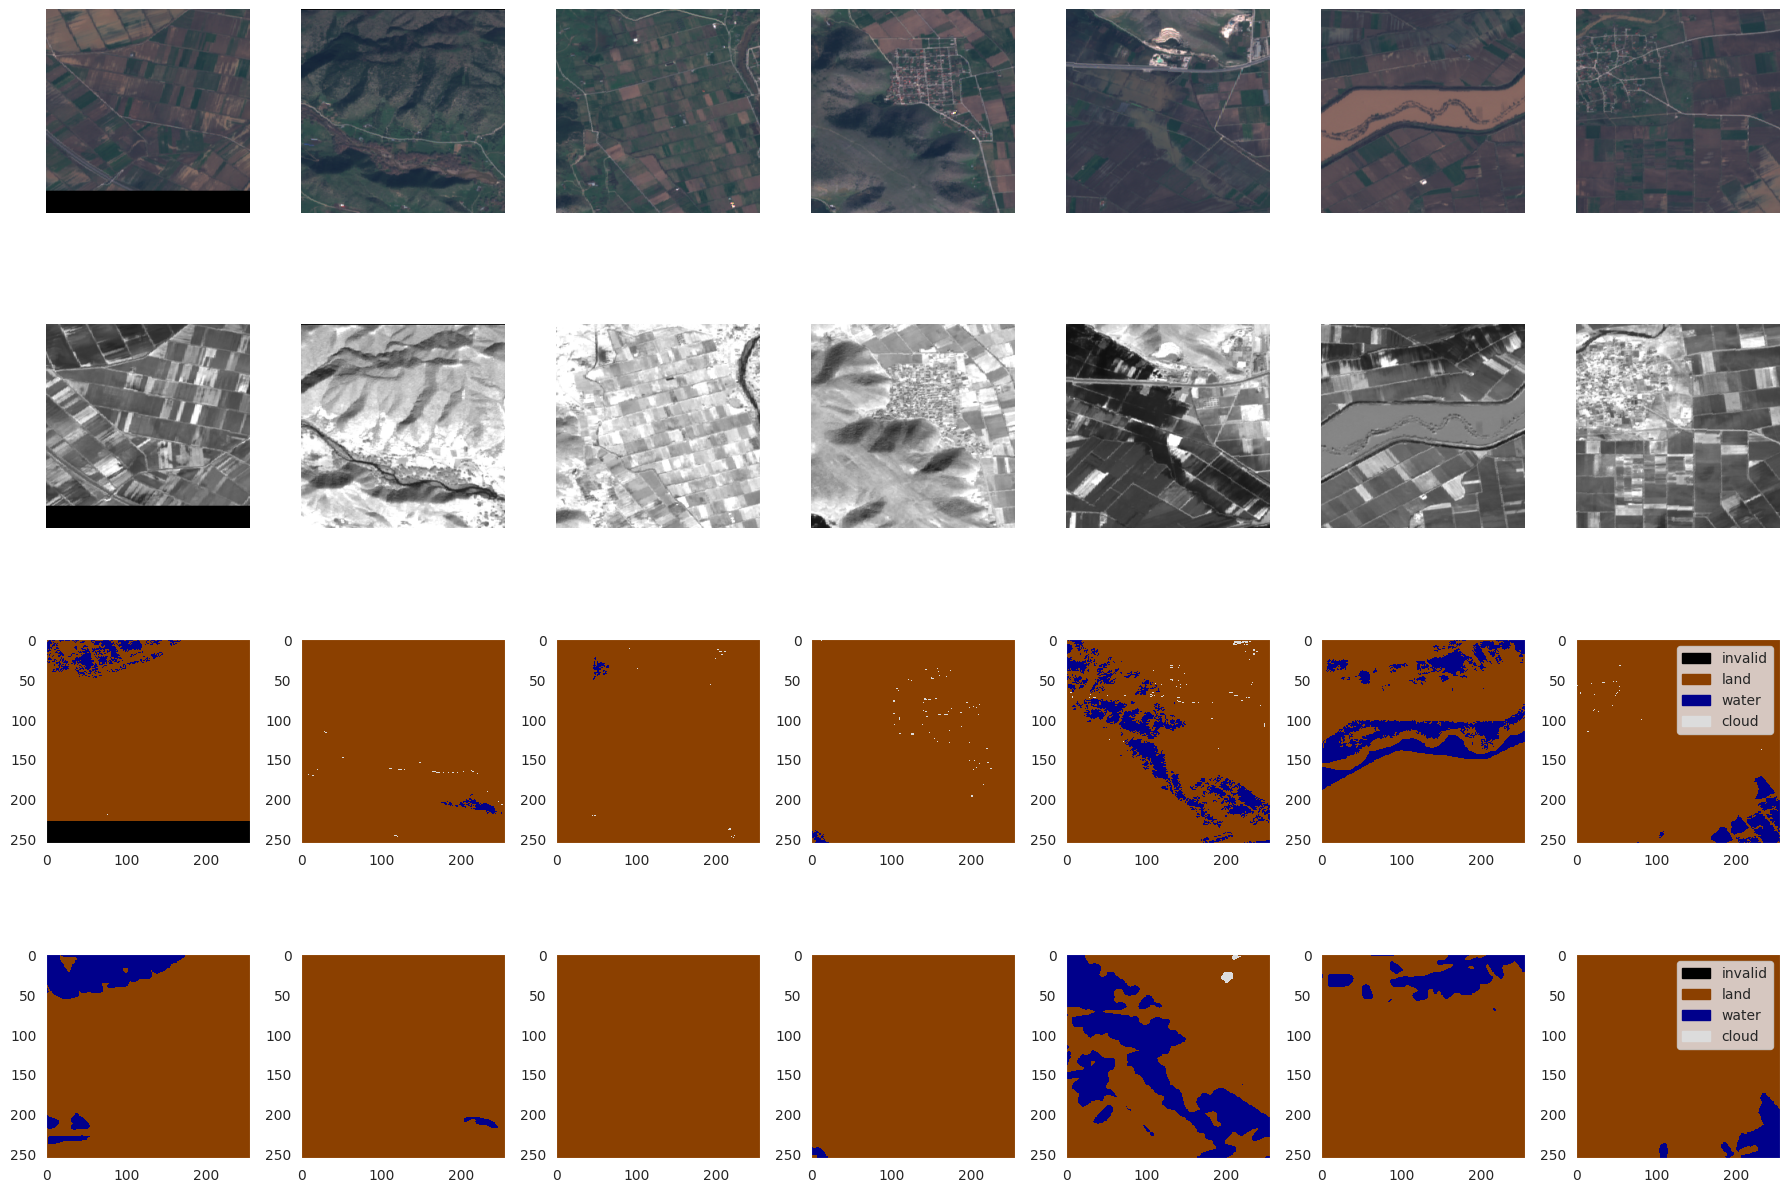

In [23]:
n_image_start=7
n_images=14
count=int(n_images-n_image_start)
fig, axs = plt.subplots(4, count, figsize=(18,14),tight_layout=True)
importlib.reload(flooding_model)
flooding_model.plot_batch(batch_val["image"][n_image_start:n_images],channel_configuration="bgri",axs=axs[0],max_clip_val=3500.)
flooding_model.plot_batch(batch_val["image"][n_image_start:n_images],channel_configuration="bgri",bands_show=["B8","B8", "B8"],axs=axs[1],max_clip_val=3500.)
# flooding_model.plot_batch(batch_val["image"][:n_images],bands_show=["B11","B8", "B4"],axs=axs[1],max_clip_val=4500.)
flooding_model.plot_batch_output_v1(batch_val["mask"][n_image_start:n_images, 0],axs=axs[2], show_axis=True)
flooding_model.plot_batch_output_v1(prediction[n_image_start:n_images] + 1,axs=axs[3], show_axis=True)

for ax in axs.ravel():
    ax.grid(False)